In [2]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/core")
)

In [3]:
from core.quantum_error_correction_code import SurfaceCode
from core.neural_network import CNNDecoder, CNNDual, load_params
from core.perfect_maximum_likelihood_decoder import PMLD

from pymatching import Matching
import jax.numpy as jnp
from jax import random, vmap, jit
import matplotlib.pyplot as plt
import json

In [4]:
distances = [3, 5, 7]
decoders = ["PML", "MWPM", "CNN", "CNN-S", "CNN-G"]
deformation_names = ['CSS', 'XZZX', 'XY', 'C1']

p, nu = .01, 500
ERROR_PROBS = jnp.array([
    1 / (2 * (nu + 1)) * p,
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
])

In [4]:
def get_data_on_deformation(
    data_key,
    code: SurfaceCode,
    batch_size: int,
    parity_info: tuple[jnp.ndarray],
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, any]:
    data_key = random.split(data_key, num=batch_size+1)
    errors = vmap(
        code.error,
        in_axes=(0, None),
        out_axes=0
    )(data_key[:-1], ERROR_PROBS)
    imgs, logicals = vmap(
        code.syndrome_img,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    syndromes, _ = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    return imgs[:,None,:,:], syndromes, logicals, data_key[-1]

def logicals_of_recovery(
    code: SurfaceCode,
    recovery: jnp.ndarray,
    parity_info: tuple[jnp.ndarray],
) -> jnp.ndarray:
    _, logicals = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(recovery, parity_info)
    return logicals

In [5]:
def evaluate_nn_decoder_batch(
    data_key: jnp.ndarray,
    decoder: CNNDual | CNNDecoder,
    model_params: jnp.ndarray,
    code: SurfaceCode,
    deformation: jnp.ndarray,
    batch_size: int,
) -> jnp.ndarray:
    parity_info = code.deformation_parity_info(deformation)
    syndrome_imgs, syndromes, logicals, data_key = get_data_on_deformation(
        data_key,
        code,
        batch_size,
        parity_info
    )
    if isinstance(decoder, CNNDecoder):
        preds = decoder.apply_batch(model_params, syndrome_imgs) > 0.0
    elif isinstance(decoder, CNNDual):
        deformation_imgs = code.deformation_image(deformation)[None, :, :, :]
        preds = decoder.apply_batch(model_params, syndrome_imgs, deformation_imgs) > 0.0
    else:
        raise ValueError("Unknown decoder type", type(decoder))

    # A logical error corresponds to the predicted logicals being different from the logicals of the physical error
    error_rate = jnp.any(logicals != preds, axis=1).mean()

    # Create a 2D histogram of the errors
    # 0: no error
    # 1: X error
    # 2: Z error
    # 3: XZ=Y error
    i = 2 * logicals[:, 0] + logicals[:, 1]
    j = 2 * preds[:, 0] + preds[:, 1]
    hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

    return error_rate, hist2d

def evaluate_mwpm_decoder(
    data_key: jnp.ndarray,
    decoder: CNNDual | CNNDecoder,
    model_params: jnp.ndarray,
    code: SurfaceCode,
    deformation: jnp.ndarray,
    batch_size: int,
) -> jnp.ndarray:
    
    parity_info_undeformed = code.deformation_parity_info(jnp.zeros_like(deformation))
    parity_info = code.deformation_parity_info(deformation)
    syndrome_imgs, syndromes, logicals, data_key = get_data_on_deformation(
        data_key,
        code,
        batch_size,
        parity_info
    )

    # Pretend the syndrome come from the undeformed code and find the recovery operation
    # The recovery can be deformed to recover the errors in the deformed code.
    # The logicals will however be the same. Since we are only interested in the logicals, we can
    # use the undeformed codes logicals as that requires less code.
    recovery_undeformed = decoder.decode_batch(syndromes)
    recovery_undeformed = recovery_undeformed.reshape((recovery_undeformed.shape[0], 2, recovery_undeformed.shape[1]//2))
    preds = logicals_of_recovery(code, recovery_undeformed, parity_info_undeformed)

    # A logical error corresponds to the predicted logicals being different from the logicals of the physical error
    error_rate = jnp.any(logicals != preds, axis=1).mean()

    # Create a 2D histogram of the errors
    # 0: no error
    # 1: X error
    # 2: Z error
    # 3: XZ=Y error
    i = 2 * logicals[:, 0] + logicals[:, 1]
    j = 2 * preds[:, 0] + preds[:, 1]
    hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

    return error_rate, hist2d

def evaluate_decoder(
    data_key: jnp.ndarray,
    decoder: CNNDual | CNNDecoder | Matching,
    model_params: jnp.ndarray,
    code: SurfaceCode,
    deformation: jnp.ndarray,
    batch_size: int,
    num_errors: int,
):
    error_rates = jnp.empty(num_errors // batch_size)
    hist2d = jnp.zeros((4, 4), dtype=int)

    keys = random.split(data_key, error_rates.shape[0])
    if isinstance(decoder, (CNNDecoder, CNNDual)):
        evaluate_fn = evaluate_nn_decoder_batch
    elif isinstance(decoder, Matching):
        evaluate_fn = evaluate_mwpm_decoder
    else:
        raise ValueError("Unknown decoder type", type(decoder))
    for i in range(error_rates.shape[0]):
        error_rate_, hist2d_ = evaluate_fn(
            keys[i],
            decoder,
            model_params,
            code,
            deformation,
            batch_size
        )
        error_rates = error_rates.at[i].set(error_rate_)
        hist2d = hist2d + hist2d_
    return error_rates.mean(), hist2d / (error_rates.shape[0] * batch_size)

In [ ]:
table = jnp.empty((5*len(distances), 4), dtype=jnp.float32)
hist2d_dict = {}

batch_size=10_000
num_errors=10_000_000

for l, L in enumerate(distances):
    code = SurfaceCode(L)

    # Use the same key every time to ensure that all the decoders see the same set of errors and thus ensure fair comparison between decoders
    key = random.key(723)

    for m, decoder in enumerate(decoders):
        print(f"\nDistance {L} with decoder {decoder} ", end='')
        for n, deformation in enumerate([
            jnp.zeros(L**2, dtype=jnp.int32),
            jnp.zeros(L**2, dtype=jnp.int32).at[::2].set(3),
            jnp.zeros(L**2, dtype=jnp.int32).at[:].set(2),
            jnp.zeros((L, L), dtype=jnp.int32).at[1::2, ::2].set(3).flatten().at[::2].set(2)
        ]):
            print(".", end='')
            
            parity_info = code.deformation_parity_info(deformation)

            if decoder == "PML" and L == 3:
                perfect_decoder = PMLD(code, ERROR_PROBS, parity_info)
                table = table.at[5*l+m, n].set(perfect_decoder.exact_logical_error_rate())
                hist2d_dict[f"{L}-{decoder}-{deformation_names[n]}"] = perfect_decoder.hist2d
            elif decoder == "MWPM":
                # The decoder assumes the syndromes are from the undeformed code and the errors are the once that are deformed.
                # This is possible by switching to the Heisenberg picture there it is the noise model that is nonuniform.
                # Its recovery can be deformed to recover the errors in the deformed code.
                # The logicals will however be the same.
                matcher = Matching(
                    jnp.append(code.hx_original, code.hz_original, axis=1)
                )
                error_rate, hist2d = evaluate_decoder(
                    key,
                    matcher,
                    None,
                    code,
                    deformation,
                    batch_size,
                    num_errors
                )
                table = table.at[5*l+m, n].set(error_rate)
                hist2d_dict[f"{L}-{decoder}-{deformation_names[n]}"] = hist2d
            elif decoder == "CNN":
                model_name = f"data/CNN-{L}-{''.join([str(d) for d in deformation])}.json"
                try:
                    settings, model_params = load_params(model_name)
                except FileNotFoundError:
                    table = table.at[5*l+m, n].set(jnp.nan)
                    continue
                model = CNNDecoder(
                    input_shape = (1, L+1, L+1),
                    conv_layers = [tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS"]],
                    fc_layers = [int(v) for v in settings["FC_LAYERS"]],
                )
                error_rate, hist2d = evaluate_decoder(
                    key,
                    model,
                    model_params,
                    code,
                    deformation,
                    batch_size,
                    num_errors
                )
                table = table.at[5*l+m, n].set(error_rate)
                hist2d_dict[f"{L}-{decoder}-{deformation_names[n]}"] = hist2d
            elif decoder == "CNN-S":
                model_name = f"data/CNN-S-{L}-{''.join([str(d) for d in deformation])}.json"
                try:
                    settings, model_params = load_params(model_name)
                except FileNotFoundError:
                    print("(FileNotFoundError)", end="")
                    table = table.at[5*l+m, n].set(jnp.nan)
                    continue
                model = CNNDual(
                    input_shape_1=(1, L+1, L+1),
                    input_shape_2=(1, L, L),
                    conv_layers_input_1=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_1"]],
                    conv_layers_input_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_2"]],
                    conv_layers_stage_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_STAGE_2"]],
                    fc_layers=[int(v) for v in settings["FC_LAYERS"]],
                )
                error_rate, hist2d = evaluate_decoder(
                    key,
                    model,
                    model_params,
                    code,
                    deformation,
                    batch_size,
                    num_errors
                )
                table = table.at[5*l+m, n].set(error_rate)
                hist2d_dict[f"{L}-{decoder}-{deformation_names[n]}"] = hist2d
            elif decoder == "CNN-G":
                model_name = f"data/CNN-G-{L}.json"
                try:
                    settings, model_params = load_params(model_name)
                except FileNotFoundError:
                    table = table.at[5*l+m, n].set(jnp.nan)
                    continue
                model = CNNDual(
                    input_shape_1=(1, L+1, L+1),
                    input_shape_2=(1, L, L),
                    conv_layers_input_1=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_1"]],
                    conv_layers_input_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_2"]],
                    conv_layers_stage_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_STAGE_2"]],
                    fc_layers=[int(v) for v in settings["FC_LAYERS"]],
                )
                error_rate, hist2d = evaluate_decoder(
                    key,
                    model,
                    model_params,
                    code,
                    deformation,
                    batch_size,
                    num_errors
                )
                table = table.at[5*l+m, n].set(error_rate)
                hist2d_dict[f"{L}-{decoder}-{deformation_names[n]}"] = hist2d
            else:
                table = table.at[5*l+m, n].set(jnp.nan)

data = {
    key: arr.tolist()
    for key, arr 
    in hist2d_dict.items()
}

with open("data/decoder_comparison_hist2d.json", "w") as file:
    json.dump(data, file, indent=4)
jnp.save("data/decoder_comparison_error_rates.npy", table)

table


Distance 3 with decoder PML ....
Distance 3 with decoder MWPM ....
Distance 3 with decoder CNN ....
Distance 3 with decoder CNN-S ....
Distance 3 with decoder CNN-G ....
Distance 5 with decoder PML ....
Distance 5 with decoder MWPM ....
Distance 5 with decoder CNN ....
Distance 5 with decoder CNN-S ....
Distance 5 with decoder CNN-G ....
Distance 7 with decoder PML ....
Distance 7 with decoder MWPM ....
Distance 7 with decoder CNN ....
Distance 7 with decoder CNN-S ....
Distance 7 with decoder CNN-G ....

Array([[1.72710419e-03, 3.53753567e-04, 8.92877579e-05, 2.50339508e-05],
       [1.73569995e-03, 8.16499989e-04, 3.42800003e-03, 1.75410009e-03],
       [1.74520002e-03, 4.02799982e-04, 1.02799997e-04, 2.90000007e-05],
       [1.73670007e-03, 4.08400025e-04, 9.92999994e-05, 3.14999997e-05],
       [1.77949993e-03, 3.91199981e-04, 3.92199989e-04, 1.54299996e-04],
       [           nan,            nan,            nan,            nan],
       [2.73199985e-04, 6.11999931e-05, 5.41000045e-04, 1.90699982e-04],
       [3.11399985e-04, 3.31999981e-05, 9.64999999e-05, 1.61000007e-05],
       [2.88799987e-04, 2.89000000e-05, 2.75999992e-05, 1.07999995e-05],
       [3.17999977e-04, 6.82999962e-05, 1.76300004e-04, 7.03000042e-05],
       [           nan,            nan,            nan,            nan],
       [4.24999998e-05, 4.20000060e-06, 8.19999987e-05, 2.09000009e-05],
       [8.13999941e-05, 2.07000012e-05, 1.94499982e-04, 3.31000010e-05],
       [1.07399996e-04, 2.61000005e-05, 1.57200004e

In [5]:
with open("data/decoder_comparison_hist2d.json", "r") as file:
    data = json.load(file)

decoder_comparison_hist2d-3-C1


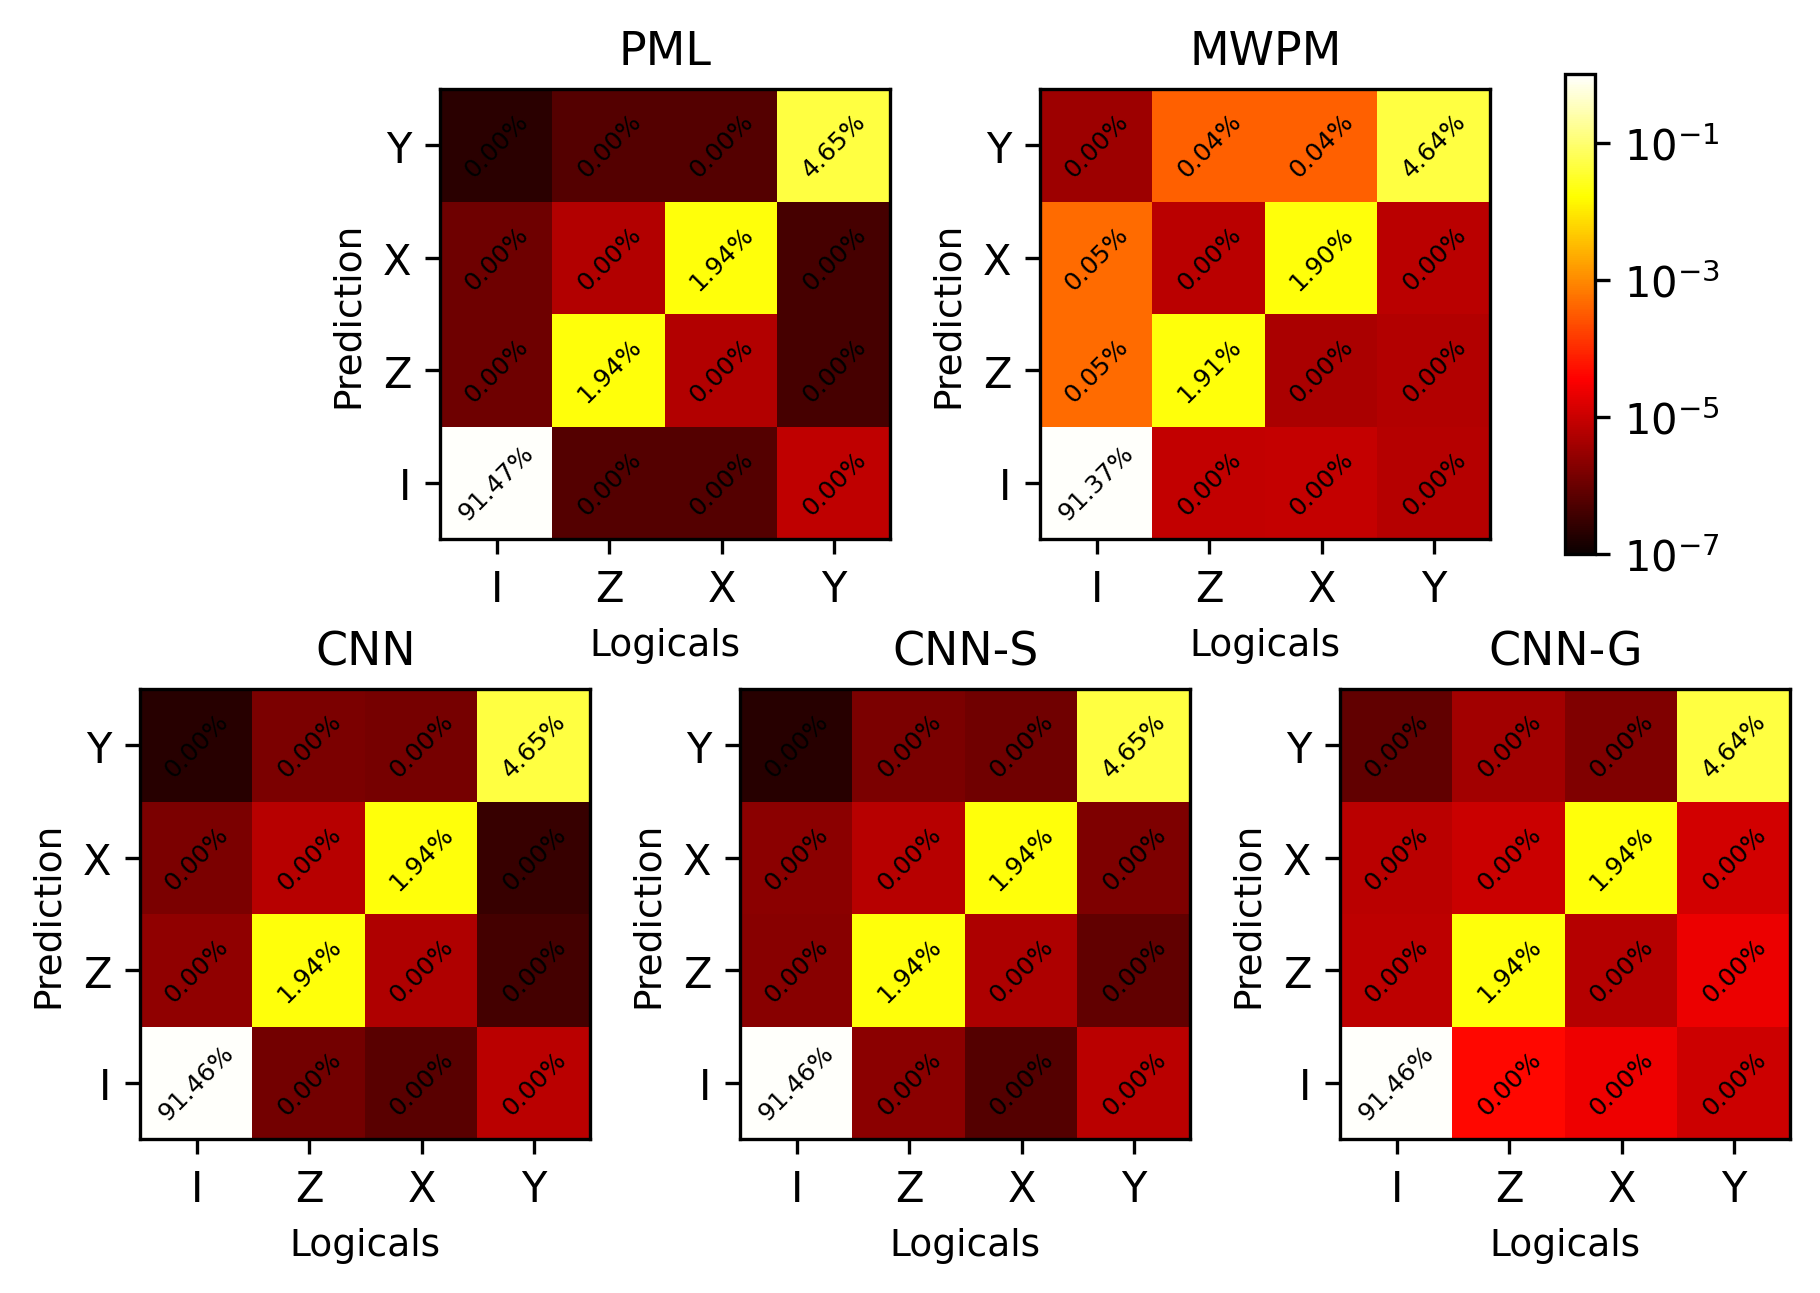

In [78]:
from matplotlib.colors import LogNorm

labels = ['I', 'Z', 'X', 'Y']
width = .75
L = 3
deformation_name = 'C1'

fig = plt.figure(dpi=300, figsize=(2,2))
for decoder, loc in zip(
    # ['PML', 'MWPM', 'CNN'],
    # [(0,0), (1,0), (2,0)]
    # ['MWPM', 'CNN', 'CNN-S', 'CNN-G'],
    # [(0,0.2), (1,0.2), (0,-1), (1,-1)]
    ['PML', 'MWPM', 'CNN', 'CNN-S', 'CNN-G'],
    [(.5,0), (1.5,0), (0,-1), (1,-1), (2,-1)]
):
    ax = fig.add_axes((loc[0]+(1-width)/2, loc[1]+(1-width)/2, width, width))
    hist = data[f"{L}-{decoder}-{deformation_name}"]
    img = ax.imshow(
        hist, 
        origin='lower', 
        cmap='hot',
        # vmin=0,
        # vmax=hist.sum(),
        norm=LogNorm(vmin=1E-7, vmax=1)
    )
    img.cmap.set_bad(color='black')
    ax.set_xticks(range(4), labels)
    ax.set_yticks(range(4), labels)
    ax.set_ylabel(f'Prediction', fontsize=9)
    ax.set_xlabel(f'Logicals', fontsize=9)
    for x, row in enumerate(jnp.array(hist).T):
        for y, prob in enumerate(row):
            ax.text(x, y, f'{prob:.2%}', ha='center', va='center', rotation=45, rotation_mode='anchor', fontsize=6)
    ax.set_title(f'{decoder}', fontsize=11)
# cbar = fig.colorbar(img, cax=fig.add_axes((2.95,0.1,.05,.8)))
# cbar = fig.colorbar(img, cax=fig.add_axes((2.5,0.1,.05,.8)))
cbar = fig.colorbar(img, cax=fig.add_axes((2.5,0.1,.05,.8)))
# cbar.set_label("Probability")

figname = f"decoder_comparison_hist2d-{L}-{deformation_name}"
print(figname)
plt.savefig(f"figs/{figname}.eps", dpi=300, bbox_inches='tight')
plt.savefig(f"figs/{figname}.pdf", dpi=300, bbox_inches='tight')
plt.savefig(f"figs/{figname}.png", dpi=300, bbox_inches='tight')

plt.show()

decoder_comparison_hist2d-3


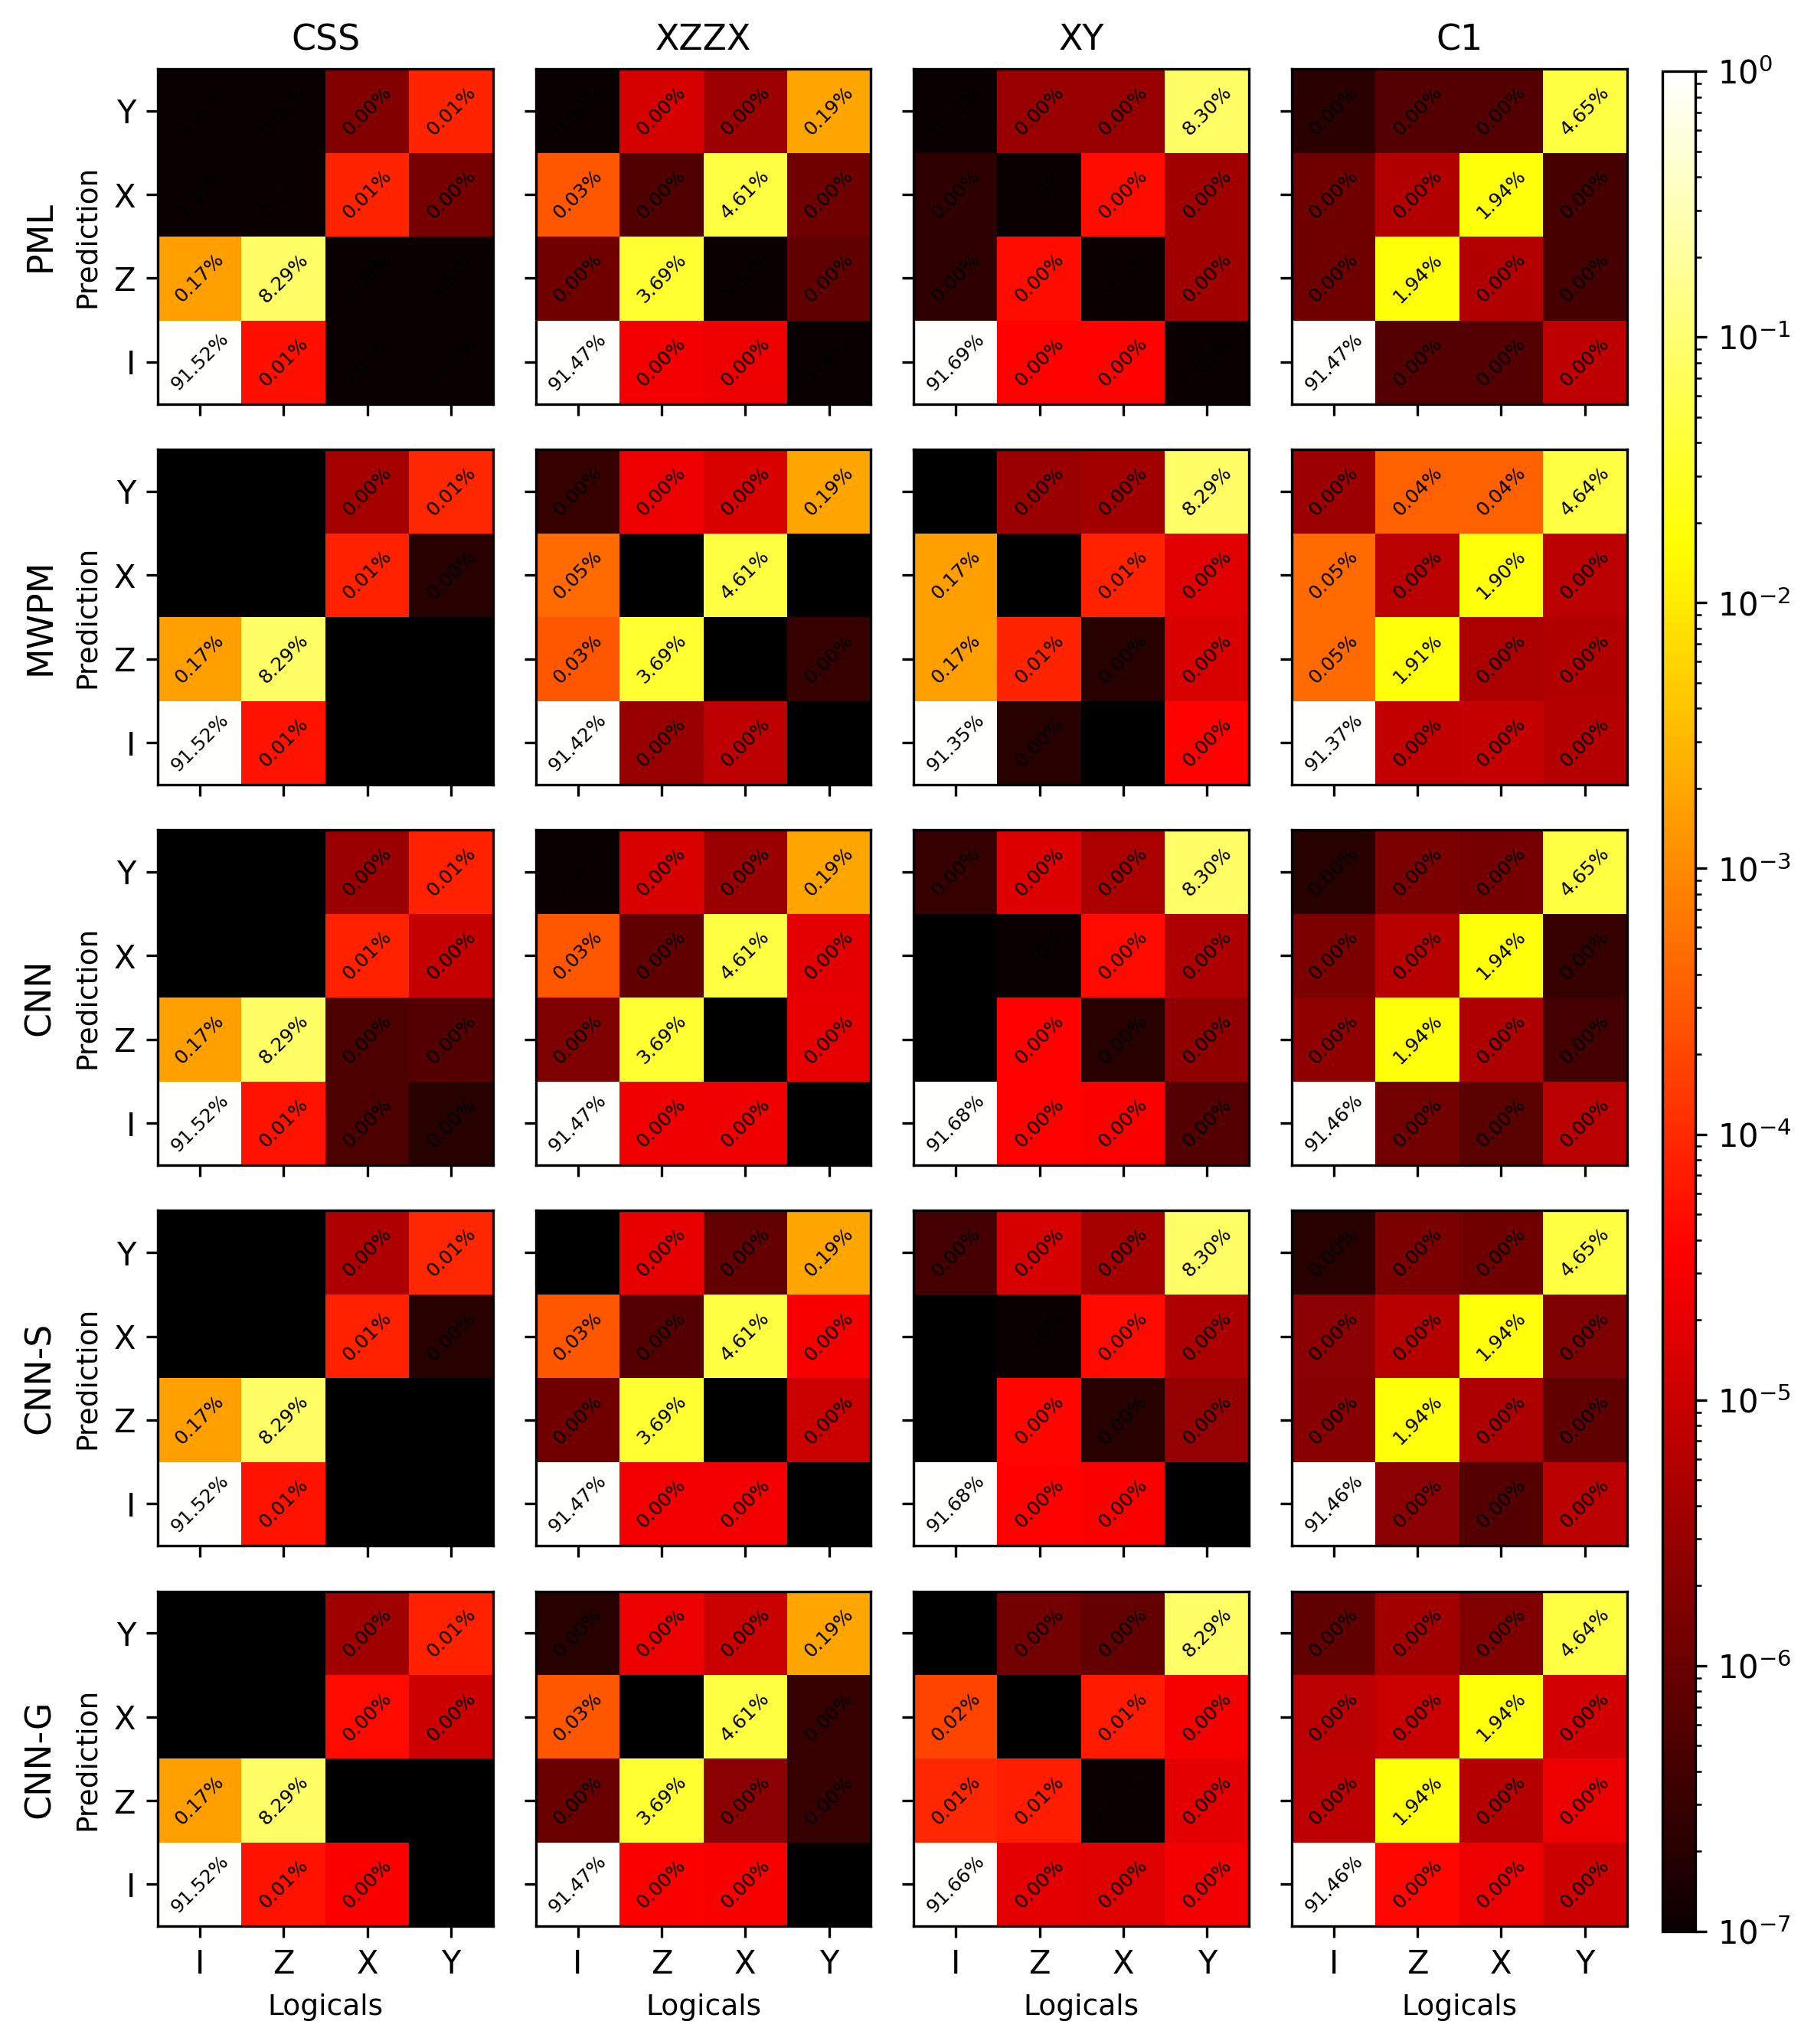

In [89]:
L = 3
if L == 3:
    decoders = ["PML", "MWPM", "CNN", "CNN-S", "CNN-G"]
else:
    decoders = ["MWPM", "CNN", "CNN-S", "CNN-G"]
deformation_names = ['CSS', 'XZZX', 'XY', 'C1']

fig, axs = plt.subplots(
    nrows=len(decoders),
    ncols=len(deformation_names),
    figsize=(len(deformation_names)*1.8, len(decoders)*1.8),
    dpi=300,
    sharey=True,
    sharex=True,
)

# Add decoder labels to the left of each row
for i, decoder in enumerate(decoders):
    axs[i, 0].annotate(
        decoder,
        xy=(-0.3, 0.5),
        xycoords='axes fraction',
        ha='right',
        va='center',
        fontsize=11,
        rotation=90
    )
for i, decoder in enumerate(decoders):
    for j, deformation in enumerate(deformation_names):
        ax = axs[i, j]
        hist = data[f"{L}-{decoder}-{deformation}"]
        img = ax.imshow(
            hist, 
            origin='lower', 
            cmap='hot',
            norm=LogNorm(vmin=1E-7, vmax=1)
        )
        img.cmap.set_bad(color='black')
        ax.set_xticks(range(4), labels)
        ax.set_yticks(range(4), labels)
        if j == 0:
            ax.set_ylabel(f'Prediction', fontsize=9)
        if i == len(decoders)-1:
            ax.set_xlabel(f'Logicals', fontsize=9)
        for x, row in enumerate(jnp.array(hist).T):
            for y, prob in enumerate(row):
                ax.text(x, y, f'{prob:.2%}', ha='center', va='center', rotation=45, rotation_mode='anchor', fontsize=6)
        if i == 0:
            ax.set_title(f'{deformation}', fontsize=11)
plt.tight_layout()

cbar = fig.colorbar(img, cax=fig.add_axes((1,0.06,.02,.9)))

figname = f"decoder_comparison_hist2d-{L}"
print(figname)
plt.savefig(f"figs/{figname}.eps", dpi=300, bbox_inches='tight')
plt.savefig(f"figs/{figname}.pdf", dpi=300, bbox_inches='tight')
plt.savefig(f"figs/{figname}.png", dpi=300, bbox_inches='tight')

plt.show()

In [11]:
import pandas as pd

df = pd.DataFrame(table)
df.columns = ["CSS", "XZZX", "XY", "C1"]
df.index = [f"{decoder} - {L}" for L in distances for decoder in ["PML", "MWPM", "CNN", "CNN-S", "CNN-G"]]
df

,CSS,XZZX,XY,C1
PML - 3,0.001727,0.000354,0.000089,0.000025
MWPM - 3,0.001736,0.000816,0.003428,0.001754
CNN - 3,0.001745,0.000403,0.000103,0.000029
CNN-S - 3,0.001737,0.000408,0.000099,0.000031
CNN-G - 3,0.001779,0.000391,0.000392,0.000154
PML - 5,NaN,NaN,NaN,NaN
MWPM - 5,0.000273,0.000061,0.000541,0.000191
CNN - 5,0.000311,0.000033,0.000096,0.000016
CNN-S - 5,0.000289,0.000029,0.000028,0.000011
CNN-G - 5,0.000318,0.000068,0.000176,0.000070


In [12]:
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np

# Normalize the values for coloring
norm = mcolors.Normalize(vmin=-6, vmax=-2)
cmap = plt.cm.viridis

def num_to_latex(num):
    if jnp.isnan(num):
        return ""
    if num == 0:
        return "0.0"
    num = float(f"{num:.2E}")
    val, power = f"{num:.2E}".split("E")
    val = float(val)
    power = int(power)
    return f"${val:.2f}\\times10^{{{power}}}$"

def get_cell_color(val):
    if np.isnan(val):
        return "white"
    rgba = cmap(norm(val))
    rgb = tuple(int(255 * c) for c in rgba[:3])
    return f"\\cellcolor[RGB]{{{rgb[0]},{rgb[1]},{rgb[2]}}}"

latex_code = "\\toprule\n"
latex_code += "    $L$&Decoder&CSS&  XZZX&  XY& C1\\\\\n"
latex_code += "\\midrule\n"

decoders = ["PML", "MWPM", "CNN", "CNN-S", "CNN-G"]
for l, L in enumerate(distances):
    for m, decoder in enumerate(decoders):
        if decoder == "PML" and L != 3:
            continue
        row = f"    {L}&{decoder}"
        for n in range(4):  # Iterate over CSS, XZZX, XY, C1
            val = table[5 * l + m, n]
            row += f"&{get_cell_color(jnp.log10(val))} {num_to_latex(val)}"
        row += "\\\\\n"
        latex_code += row
    if l < len(distances) - 1:
        latex_code += "\\midrule\n"
latex_code += "\\bottomrule"
print(latex_code)

\toprule
    $L$&Decoder&CSS&  XZZX&  XY& C1\\
\midrule
    3&PML&\cellcolor[RGB]{129,211,76} $1.73\times10^{-3}$&\cellcolor[RGB]{43,177,125} $3.54\times10^{-4}$&\cellcolor[RGB]{33,140,141} $8.93\times10^{-5}$&\cellcolor[RGB]{46,107,142} $2.50\times10^{-5}$\\
    3&MWPM&\cellcolor[RGB]{129,211,76} $1.74\times10^{-3}$&\cellcolor[RGB]{81,196,104} $8.16\times10^{-4}$&\cellcolor[RGB]{178,221,44} $3.43\times10^{-3}$&\cellcolor[RGB]{129,211,76} $1.75\times10^{-3}$\\
    3&CNN&\cellcolor[RGB]{129,211,76} $1.75\times10^{-3}$&\cellcolor[RGB]{47,179,123} $4.03\times10^{-4}$&\cellcolor[RGB]{32,144,140} $1.03\times10^{-4}$&\cellcolor[RGB]{45,111,142} $2.90\times10^{-5}$\\
    3&CNN-S&\cellcolor[RGB]{129,211,76} $1.74\times10^{-3}$&\cellcolor[RGB]{48,180,122} $4.08\times10^{-4}$&\cellcolor[RGB]{32,143,140} $9.93\times10^{-5}$&\cellcolor[RGB]{44,113,142} $3.15\times10^{-5}$\\
    3&CNN-G&\cellcolor[RGB]{131,211,75} $1.78\times10^{-3}$&\cellcolor[RGB]{46,178,124} $3.91\times10^{-4}$&\cellcolor[RGB]{4